<h1 style="text-align: center;">3 N-gram Language Models</h1>

> In this notebook, we illustrate some basic ideas of N-gram and LM evaluation by using the perplexity.


In [1]:
import re
import io
import math
import nltk
import pprint
import random
import numpy as np
from itertools import product
from nltk.util import ngrams
from nltk.lm import NgramCounter
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize


# make plots in center
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h2 style="text-align: center;">3.1 $N$-Grams</h2>

### Example text:

In [2]:
raw_text1 = \
"""
<s> I am Sam </s>
<s> Sam I am </s>
<s> I do not like green eggs and ham </s>
"""
print(raw_text1)


<s> I am Sam </s>
<s> Sam I am </s>
<s> I do not like green eggs and ham </s>



### Tokenize the raw text:

We tokenize it as a list of words by whitespace, you may use tokens = word_tokenize(text)

In [3]:
sentences = raw_text1.strip().split('\n')
print(f'All sentences:')
for sent in sentences:
    print(sent)
print('---')
tokens = raw_text1.replace("\n", " ").split()
print(f'All unigram tokens:\n{tokens}\n---')
vocab = set(tokens)
print(f'set of vocabulary: \n{vocab}')
print(f'{len(vocab)} words in total.')
print('---')

All sentences:
<s> I am Sam </s>
<s> Sam I am </s>
<s> I do not like green eggs and ham </s>
---
All unigram tokens:
['<s>', 'I', 'am', 'Sam', '</s>', '<s>', 'Sam', 'I', 'am', '</s>', '<s>', 'I', 'do', 'not', 'like', 'green', 'eggs', 'and', 'ham', '</s>']
---
set of vocabulary: 
{'ham', 'green', 'and', 'Sam', 'am', 'not', 'do', 'eggs', 'like', 'I', '<s>', '</s>'}
12 words in total.
---


### Get bigrams and the counts of these bigrams

In [6]:
unigrams_list = [unigram for sent in sentences 
           for unigram in nltk.ngrams(sent.split(),n=1)]
bigrams_list = [bigram for sent in sentences 
           for bigram in nltk.bigrams(sent.split())]
print('All unigrams:\n', unigrams_list)
print('All bigrams:\n', bigrams_list)

All unigrams:
 [('<s>',), ('I',), ('am',), ('Sam',), ('</s>',), ('<s>',), ('Sam',), ('I',), ('am',), ('</s>',), ('<s>',), ('I',), ('do',), ('not',), ('like',), ('green',), ('eggs',), ('and',), ('ham',), ('</s>',)]
All bigrams:
 [('<s>', 'I'), ('I', 'am'), ('am', 'Sam'), ('Sam', '</s>'), ('<s>', 'Sam'), ('Sam', 'I'), ('I', 'am'), ('am', '</s>'), ('<s>', 'I'), ('I', 'do'), ('do', 'not'), ('not', 'like'), ('like', 'green'), ('green', 'eggs'), ('eggs', 'and'), ('and', 'ham'), ('ham', '</s>')]


In [9]:
# FreqDist can help to get counts
freq_dist = FreqDist(unigrams_list + bigrams_list)
for gram, freq in freq_dist.items():
    if len(gram) == 2:
        print(f'gram: {gram}', freq, f', bigram prob.: {freq / freq_dist[(gram[0],)]:.6f}')
    else:
        print(f'gram: {gram}', freq)

# most of the bigrams have zero probabilities.
print(f'the following bigrams have zero probability: ')
zeros = 0
for v1, v2 in product(vocab, vocab):
    if (v1, v2) not in freq_dist:
        zeros += 1
        print(f'{(v1, v2)} ', end=' ')

print(f'\nThere is {zeros} zero-prob bigrams in total!')

gram: ('<s>',) 3
gram: ('I',) 3
gram: ('am',) 2
gram: ('Sam',) 2
gram: ('</s>',) 3
gram: ('do',) 1
gram: ('not',) 1
gram: ('like',) 1
gram: ('green',) 1
gram: ('eggs',) 1
gram: ('and',) 1
gram: ('ham',) 1
gram: ('<s>', 'I') 2 , bigram prob.: 0.666667
gram: ('I', 'am') 2 , bigram prob.: 0.666667
gram: ('am', 'Sam') 1 , bigram prob.: 0.500000
gram: ('Sam', '</s>') 1 , bigram prob.: 0.500000
gram: ('<s>', 'Sam') 1 , bigram prob.: 0.333333
gram: ('Sam', 'I') 1 , bigram prob.: 0.500000
gram: ('am', '</s>') 1 , bigram prob.: 0.500000
gram: ('I', 'do') 1 , bigram prob.: 0.333333
gram: ('do', 'not') 1 , bigram prob.: 1.000000
gram: ('not', 'like') 1 , bigram prob.: 1.000000
gram: ('like', 'green') 1 , bigram prob.: 1.000000
gram: ('green', 'eggs') 1 , bigram prob.: 1.000000
gram: ('eggs', 'and') 1 , bigram prob.: 1.000000
gram: ('and', 'ham') 1 , bigram prob.: 1.000000
gram: ('ham', '</s>') 1 , bigram prob.: 1.000000
the following bigrams have zero probability: 
('I', 'I')  ('I', 'and')  ('I',

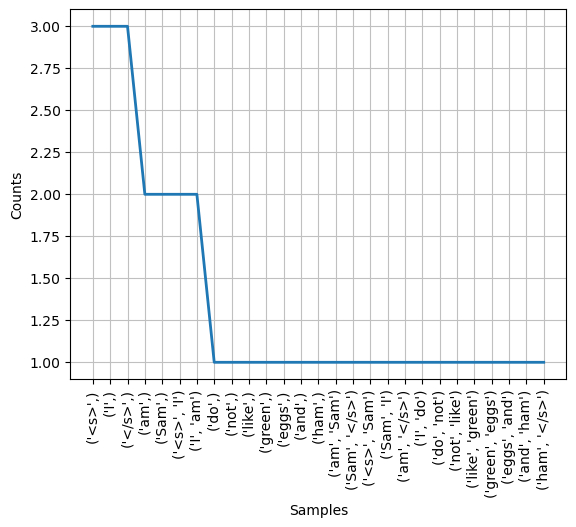

<Axes: xlabel='Samples', ylabel='Counts'>

In [10]:
# draw the frequency distribution
freq_dist.plot()

<h2 style="text-align: center;">3.2 Building and evaluating LMs</h2>

### Load all books written by Jane Austen and split it as train and test dataset

> The main part of section follows from [Joshua Floehr's code](https://github.com/joshualoehr/ngram-language-model).

In [11]:
with open('datasets/dataset_jane-austen_all.txt', 'r') as file:
    raw_text_jane = file.read()
raw_text_jane = raw_text_jane.replace("\n", " ")
print(raw_text_jane[:200], raw_text_jane[-200:])

The Project Gutenberg eBook of The Complete Project Gutenberg Works of Jane Austen      This ebook is for the use of anyone anywhere in the United States and most other parts of the world at no cost  rg™, including how to make donations to the Project Gutenberg Literary Archive Foundation, how to help produce our new eBooks, and how to subscribe to our email newsletter to hear about new eBooks.   


In [12]:
def raw_text_preprocess(raw_text, n):
    sentences = sent_tokenize(raw_text)
    sos = "<s> " * (n-1) if n > 1 else "<s> "
    tokenized_sentences = ['{}{} {}'.format(sos, sent, "</s>").split() for sent in sentences]
    n = len(tokenized_sentences)
    tr_ind = np.random.permutation(n)[:n-1000]
    tr_sentences = [tokenized_sentences[_] for _ in tr_ind]
    te_ind = np.random.permutation(n)[n-1000:]
    te_sentences = [tokenized_sentences[_] for _ in te_ind]
    tr_tokens = [token for sublist in tr_sentences for token in sublist]
    te_tokens = [token for sublist in te_sentences for token in sublist]
    # Replace tokens which appear only once in the corpus with <UNK>
    vocab = nltk.FreqDist(tr_tokens)
    tr_tokens = [token if vocab[token] > 1 else "<UNK>" for token in tr_tokens]
    return tr_tokens, te_tokens, tr_sentences, te_sentences

In [13]:
class LanguageModel(object):
    """ Follow: https://github.com/joshualoehr/ngram-language-model """

    def __init__(self, tr_tokens, n, laplace=1):
        self.n = n
        self.laplace = laplace
        self.tokens = tr_tokens
        self.vocab  = nltk.FreqDist(self.tokens)
        self.model  = self._create_model()
        self.masks  = list(reversed(list(product((0,1), repeat=n))))
        self.special_words = ['<s>', '</s>', '<UNK>']

    def _smooth(self):
        """ Apply Laplace smoothing to N-gram frequency distribution. """
        vocab_size = len(self.vocab)

        n_grams = nltk.ngrams(self.tokens, self.n)
        n_vocab = nltk.FreqDist(n_grams)

        m_grams = nltk.ngrams(self.tokens, self.n-1)
        m_vocab = nltk.FreqDist(m_grams)

        def smoothed_count(n_gram, n_count):
            m_gram = n_gram[:-1]
            m_count = m_vocab[m_gram]
            return (n_count + self.laplace) / (m_count + self.laplace * vocab_size)

        return { n_gram: smoothed_count(n_gram, count) for n_gram, count in n_vocab.items() }

    def _create_model(self):
        """Create a probability distribution for the vocabulary of the training corpus.
        If building a unigram model, the probabilities are simple relative frequencies
        of each token with the entire corpus.
        Otherwise, the probabilities are Laplace-smoothed relative frequencies.
        """
        if self.n == 1:
            num_tokens = len(self.tokens)
            return { (unigram,): count / num_tokens for unigram, count in self.vocab.items() }
        else:
            return self._smooth()

    def _convert_oov(self, ngram):
        """Convert, if necessary, a given n-gram to one which is known by the model.
        Starting with the unmodified ngram, check each possible permutation of the n-gram
        with each index of the n-gram containing either the original token or <UNK>. Stop
        when the model contains an entry for that permutation.
        This is achieved by creating a 'bitmask' for the n-gram tuple, and swapping out
        each flagged token for <UNK>. Thus, in the worst case, this function checks 2^n
        possible n-grams before returning.

        Returns:
            The n-gram with <UNK> tokens in certain positions such that the model
            contains an entry for it.

        """
        mask = lambda ngram, bitmask: tuple((token if flag == 1 else "<UNK>" for token,flag in zip(ngram, bitmask)))

        ngram = (ngram,) if type(ngram) is str else ngram
        for possible_known in [mask(ngram, bitmask) for bitmask in self.masks]:
            if possible_known in self.model:
                return possible_known

    def perplexity(self, te_tokens):
        """Calculate the perplexity of the model against a given test corpus.
        Args:
            test_data (list of str): sentences comprising the testing corpus.
        Returns:
            The perplexity of the model as a float.
        
        """
        test_ngrams = nltk.ngrams(te_tokens, self.n)
        N = len(te_tokens)
        known_ngrams  = (self._convert_oov(ngram) for ngram in test_ngrams)
        probabilities = [self.model[ngram] for ngram in known_ngrams]

        return math.exp((-1/N) * sum(map(math.log, probabilities)))

    def _best_candidate(self, prev, i, without=[]):
        """Choose the most likely next token given the previous (n-1) tokens.
        If selecting the first word of the sentence (after the SOS tokens),
        the i'th best candidate will be selected, to create variety.
        If no candidates are found, the EOS token is returned with probability 1.
        Args:
            prev (tuple of str): the previous n-1 tokens of the sentence.
            i (int): which candidate to select if not the most probable one.
            without (list of str): tokens to exclude from the candidates list.
        Returns:
            A tuple with the next most probable token and its corresponding probability.

        """
        blacklist  = ["<UNK>"] + without
        candidates = ((ngram[-1],prob) for ngram,prob in self.model.items() if ngram[:-1]==prev)
        candidates = filter(lambda candidate: candidate[0] not in blacklist, candidates)
        candidates = sorted(candidates, key=lambda candidate: candidate[1], reverse=True)
        if len(candidates) == 0:
            return ("</s>", 1)
        else:
            return candidates[0 if prev != () and prev[-1] != "<s>" else i]
     
    def generate_sentences(self, num, min_len=12, max_len=24):
        """Generate num random sentences using the language model.
        Sentences always begin with the SOS token and end with the EOS token.
        While unigram model sentences will only exclude the UNK token, n>1 models
        will also exclude all other words already in the sentence.

        Args:
            num (int): the number of sentences to generate.
            min_len (int): minimum allowed sentence length.
            max_len (int): maximum allowed sentence length.
        Yields:
            A tuple with the generated sentence and the combined probability
            (in log-space) of all of its n-grams.

        """
        for i in range(num):
            sent, prob = ["<s>"] * max(1, self.n-1), 1
            while sent[-1] != "</s>":
                prev = () if self.n == 1 else tuple(sent[-(self.n-1):])
                blacklist = sent + (["</s>"] if len(sent) < min_len else [])
                next_token, next_prob = self._best_candidate(prev, i, without=blacklist)
                sent.append(next_token)
                prob *= next_prob
                
                if len(sent) >= max_len:
                    sent.append("</s>")

            yield ' '.join(sent), -1/math.log(prob)

### Build LMs with Add-one smoothing testing on Jane Austen's books

> 1. Tokenization for raw text of Jane Austen's books.
> 2. Build and Train LMs using add-one smoothing.

In [14]:
laplace = .1 # the parameter of add-one smoothing.
num_sent_gen = 10 # number of sentences is generated.

for n in [1,2,3]:
    print("-" * 50)
    tr_tokens, te_tokens, tr_sentences, te_sentences = raw_text_preprocess(raw_text_jane, n)
    
    print("Loading {}-gram model...".format(n))
    lm = LanguageModel(tr_tokens, n, laplace=laplace)
    print("Vocabulary size: {}".format(len(lm.vocab)))
    
    print("Generating sentences...")
    for sentence, prob in lm.generate_sentences(num_sent_gen):
        print("{} ({:.5f})".format(sentence, prob))
    
    perplexity = lm.perplexity(te_tokens)
    print("Model perplexity: {:.3f}".format(perplexity))


--------------------------------------------------
Loading 1-gram model...
Vocabulary size: 20018
Generating sentences...
<s> the to of and a I in her was not be </s> (0.02084)
<s> to of and a I in her was not be she the that had as it for with his you he have is </s> (0.00967)
<s> of and a I in her was not be she that to had as it for with his you he have is at </s> (0.00951)
<s> and a I in her was not be she that had of as it for with his you he have is at but </s> (0.00935)
<s> a I in her was not be she that had as and it for with his you he have is at but by </s> (0.00920)
<s> I in her was not be she that had as it a for with his you he have is at but by very </s> (0.00905)
<s> in her was not be she that had as it for I with his you he have is at but by very so </s> (0.00894)
<s> her was not be she that had as it for with in his you he have is at but by very so could </s> (0.00885)
<s> was not be she that had as it for with his her you he have is at but by very so could on </s> (0.

### Load all Shakespeare's work

> We downloaded Shakespeare's work at [Gutenberg](https://www.gutenberg.org/ebooks/100).

In [15]:
with open('datasets/dataset_shakespeare_all.txt', 'r') as file:
    raw_text_shakespeare = file.read()
raw_text_shakespeare = raw_text_shakespeare.replace("\n", " ")
print(raw_text_shakespeare[:200], raw_text_shakespeare[-200:])

The Project Gutenberg eBook of The Complete Works of William Shakespeare      This ebook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with a rg™, including how to make donations to the Project Gutenberg Literary Archive Foundation, how to help produce our new eBooks, and how to subscribe to our email newsletter to hear about new eBooks.   


In [ ]:
laplace = .1 # the parameter of add-one smoothing.
num_sent_gen = 10 # number of sentences is generated.

for n in [1,2,3]:
    print("-" * 50)
    tr_tokens, te_tokens, tr_sentences, te_sentences = raw_text_preprocess(raw_text_jane + raw_text_shakespeare, n)
    
    print("Loading {}-gram model...".format(n))
    lm = LanguageModel(tr_tokens, n, laplace=laplace)
    print("Vocabulary size: {}".format(len(lm.vocab)))
    
    print("Generating sentences...")
    for sentence, prob in lm.generate_sentences(num_sent_gen):
        print("{} ({:.5f})".format(sentence, prob))
    
    perplexity = lm.perplexity(te_tokens)
    print("Model perplexity: {:.3f}".format(perplexity))
